In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import pandas as pd
from operator import itemgetter
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=10)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)
import warnings
warnings.filterwarnings("ignore")

In that part we will use all the algorithms seen previously but in the case of a regression rather than a classification.

**The difference is that now our target vector (i.e. what we want to predict) is not a class (a discrete variable) but rather a number that can take a continuity of values.**

The algorithms are going to use very similar methods than the ones used in classification (if there are particularities between using a method as a classifier and using the same method as a regressor I will mention it).

**What's mainly going to change is the loss function used to train your model and the scoring used to evaluate this model.**

**For classification** we saw two main types of **loss function**:

- Cross entropy (negative loglikelihood) : all the classifiers except SVM and KNN (because KNN doesn't learn through a loss function). Note : GINI impurity is a form of entropy.

- Hinge loss function : SVM classifier.

And plenty of **scoring systems**, but at least two in depth:

- Accuracy

- Area under the ROC curve.

Note that we could have used the value of the minimized loss function as a score. But for classification problems since the loss function can be different from one model to another, the values of the loss function can be hard to compare and you will prefer a scoring method independant of your loss function.

### **In regression problems the loss functions and the scoring are metrics that you probably have seen before and so are more intuitive.**

The **two main loss functions that you will minimize while training your model are** :


- Mean square error/ quadratic loss/ L2 loss **(MSE)** : $\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{n}$

- Mean absolute error/ L1 loss **(MAE)** : $\frac{\Sigma^{n}_{i=1}|y_{i}-\hat{y}_{i}|}{n}$

Where n are the number of training examples, i the ith training example in the data set, $y_{i}$ the ground truth target value for that ith example and $\hat{y_{i}}$ the estimated value of the target for the ith example.

**Scoring to consider** here can actually be the value of the minimized loss function used (MSE or MAE) or other scoring metrics like :

_ **R squared** : $1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}$

_ **Adjusted R squared** : $1-(1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}\frac{n-1}{n-(k+1)})$ , with k the degree of freedom.

_ **Max error** : $max(|y_{i}-\hat{y}_{i}|)$

_ **Variance explained** : $1-\frac{Var(\{y_{i}-\bar{y}_{i}\}_{i})}{Var(\{y_{i}\}_{i})}$

We will use the diabetes dataset to predict diabetes progression thanks to age, sex, bodymass index, blood pressure and 6 blood serum measurements.

In [2]:
#regression dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df_diabetes = pd.concat([pd.DataFrame(diabetes['data'],columns=diabetes['feature_names']),\
                       pd.DataFrame(diabetes['target'],columns=['disease progression'])],axis=1)



(X_diabetes, y_diabetes) = load_diabetes(return_X_y = True)

df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
df_diabetes.dtypes

age                    float64
sex                    float64
bmi                    float64
bp                     float64
s1                     float64
s2                     float64
s3                     float64
s4                     float64
s5                     float64
s6                     float64
disease progression    float64
dtype: object

# Regression

## Table Of Content:

* [Data exploration](#Exploration)


* [Linear regression](#Linear-Regression)


* [KNN](#KNN)


* [SVM](#SVM)


* [Gradient Boosting](#Gradient)


* [Exo](#exo)

# A little bit on data exploration for regression <a class="anchor" id="Exploration"></a>

let's check how the different features and the target interact with each others.

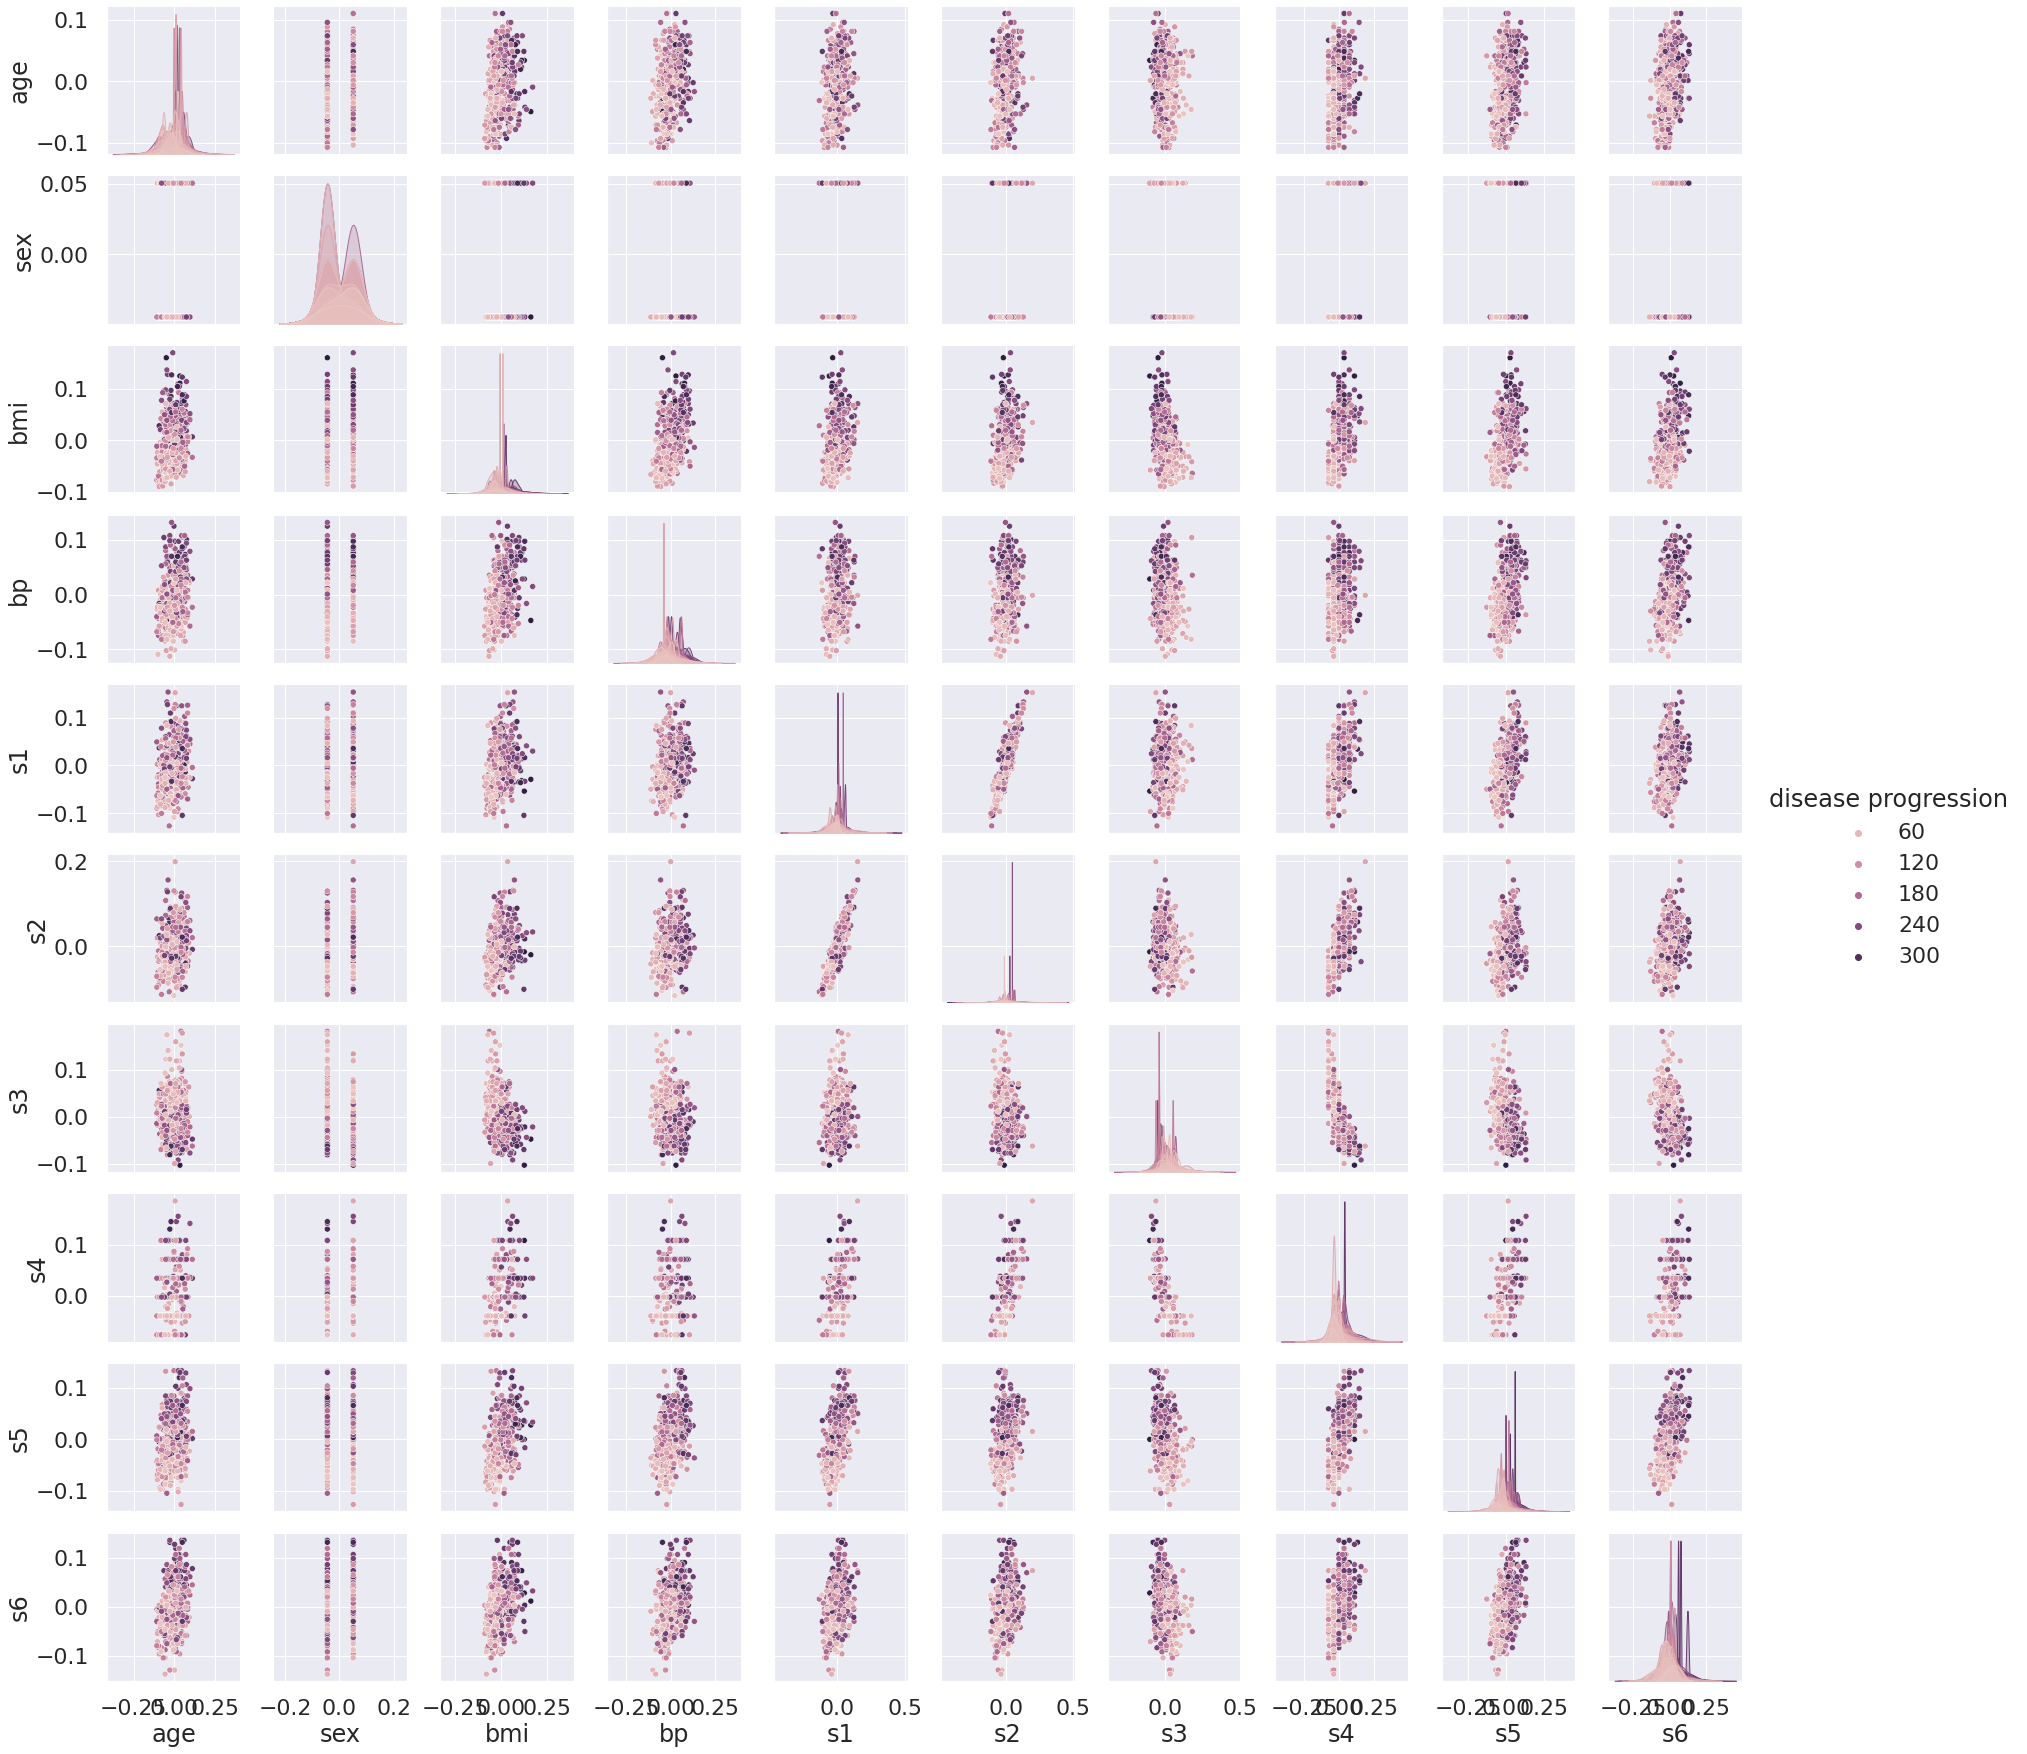

In [25]:
sns.set_context("paper", rc={"axes.labelsize":36})
sns.set(font_scale = 2)
sns.pairplot(df_diabetes,hue='disease progression')


Another representation would be to look at the correlation

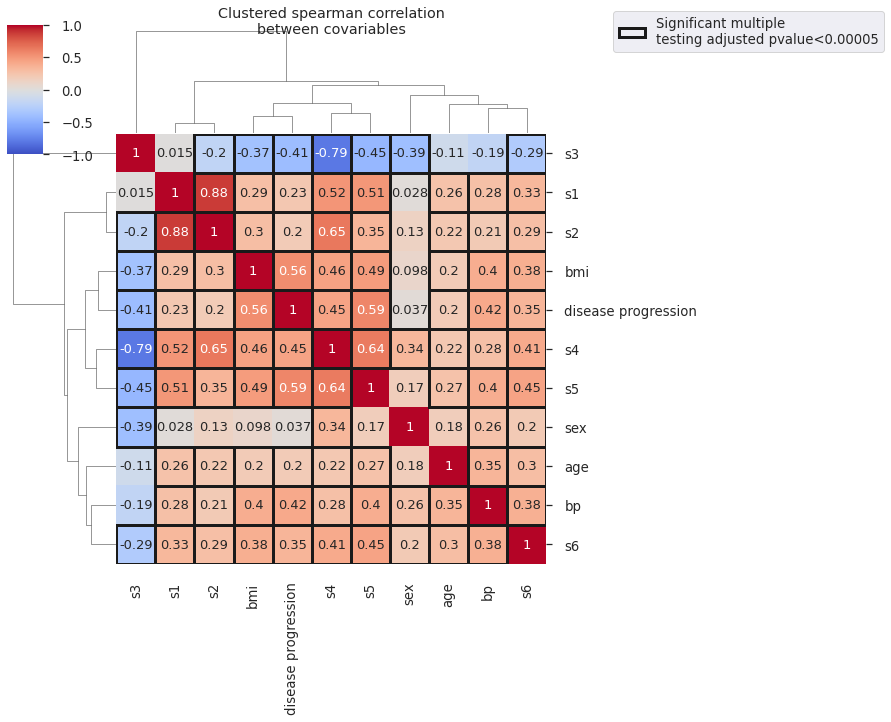

In [29]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
    return kendalltau(x,y)[1]    
    
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

sns.set(font_scale = 1.2)
corre=df_diabetes.corr(method='spearman')
corre_pval=df_diabetes.corr(method=spearmanr_pval)
df_corr_pval = pd.DataFrame(corre_pval,columns=corre.columns)

import statsmodels.stats.multitest as ssm
corre_pval_adj=np.array([list(ssm.multipletests([np.array(corre_pval)[i][j]if j!=i else 1 for j in range(np.array(corre_pval).shape[1])]
                                                ,alpha=0.05,method='fdr_bh',is_sorted=False,returnsorted=False)[1]) 
                         for i in range(np.array(corre_pval).shape[0])])
df_corr_pval_adj = pd.DataFrame(corre_pval_adj,columns=corre.columns)

dico_columns={j:i for i,j in enumerate(list(df_corr_pval_adj.columns))}
oo=['s3','s1','s2','bmi','disease progression', 's4','s5','sex','age','bp','s6']
#oo=list(df_corr_pval_adj.columns)
new_dico_columns={j:i for i,j in enumerate(oo)}

dico_swap={dico_columns[s]:new_dico_columns[s] for s in dico_columns.keys()}
dico_swap={new_dico_columns[s]:dico_columns[s] for s in dico_columns.keys()}

the_matrix2=np.array(df_corr_pval_adj)
the_matrix=np.array([[the_matrix2[dico_swap[i],dico_swap[j]] for j in range(len(the_matrix2))]for i in range(len(the_matrix2))])

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

a=sns.clustermap(corre,z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm',
                vmax=1,vmin=-1, annot=True, annot_kws={"size": 13})

a.ax_heatmap.set_title('Clustered spearman correlation\nbetween covariables',pad=100)
b=a.ax_heatmap
pp=0
for i in range(len(the_matrix)):
    for j in range(len(the_matrix)):
        if the_matrix[i][j]<0.00005:
            if pp==0:
                highlight_cell(i+0.5,j+0.5,ax=b,color='k',linewidth=3,label='Significant multiple\ntesting adjusted pvalue<0.00005')
            else:
                highlight_cell(i+0.5,j+0.5,ax=b,color='k',linewidth=3)
            pp+=1
b.legend(loc='best', bbox_to_anchor=(1, 0.8, 0.8, 0.5))
plt.show()

We can already see here that bmi and s5 are the best two features correlating to our target disease progression. We can choose another threshold using again the SelectKBest feature for example. But this time we will need other scores than the ones seen before.

We have the choice between calculating a F score from a correlation score (f.regression) between a feature and the target. If we have no reason to believe that a linear relationship exists between that feature and the target we can calculate a mutual information between those two.

The f.regression is going to look a lot like the correlation score previously explored. But remember we are not only talking about correlation strenght between a feature and the target here. With the F-score we measure how this correlation is different from other correlations with other features.

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

skb = SelectKBest(f_regression, k=2)#creating the object SelectKBest and settling for 2 best features (k=2) in term of F score
skb.fit(df_diabetes[list(df_diabetes.columns)[:-1]], df_diabetes[list(df_diabetes.columns)[-1]])#calculating the F score for each features

dico_pval={df_diabetes.columns[i]:v for i,v in enumerate(skb.pvalues_)}
print(sorted([[s,dico_pval[s]] for s in dico_pval.keys()],key=itemgetter(1)))#all the features and the F score pvalues associated. use .pvalues_

X_new=skb.transform(df_diabetes[list(df_diabetes.columns)[:-1]])# keep only the k=2 best features according to the score


[['bmi', 3.466006445166649e-42], ['s5', 8.823754157327592e-39], ['bp', 1.6485327478616884e-22], ['s4', 2.3042532817539105e-21], ['s3', 6.162864695183689e-18], ['s6', 7.580083266084625e-17], ['s1', 6.92071178775916e-06], ['age', 7.05568614911548e-05], ['s2', 0.00023598480959851294], ['sex', 0.3664292946520661]]


In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

skb = SelectKBest(mutual_info_regression, k=2)#creating the object SelectKBest and settling for 2 best features (k=2) in term of MI
skb.fit(df_diabetes[list(df_diabetes.columns)[:-1]], df_diabetes[list(df_diabetes.columns)[-1]])#calculating MI for each features

dico_MI={df_diabetes.columns[i]:v for i,v in enumerate(skb.scores_)}
print(sorted([[s,dico_MI[s]] for s in dico_MI.keys()],key=itemgetter(1),reverse=True))#all the features and MI associated. use .scores_
#note that with f score we interested in small pvalues, whereas here we are interested in high MI score
X_new=skb.transform(df_diabetes[list(df_diabetes.columns)[:-1]])# keep only the k=2 best features according to the score


[['bmi', 0.1737177231097875], ['s5', 0.1492032478130043], ['s6', 0.11923818127907904], ['s4', 0.09777109950466834], ['s1', 0.06679316173131644], ['s3', 0.060203841515113155], ['bp', 0.05843885242999969], ['sex', 0.023675012796704697], ['s2', 0.01392263192734422], ['age', 0.004618631851724508]]


As you can see, there are some differencies between the two scores probably coming from the more or less prominent non linear relation between those features and our target.

# Linear regression ++ <a class="anchor" id="Linear-Regression"></a>

Let's start with a basic 1D linear regression that you know : 

we will fit our data with a model of the form y=aX+b and the fit will be done by minimizing the mean square error. We can evaluate the model either using a R-squared or even the mean square error directly. At first let's not put any regularization.

epsilon 0
fit param [0. 3.] 1.0
true param [0, 3] 1

epsilon 1
fit param [0.         2.81854993] 1.029086627392597
true param [0, 3] 1

epsilon 10
fit param [0.         5.63926898] 0.20315848922145335
true param [0, 3] 1



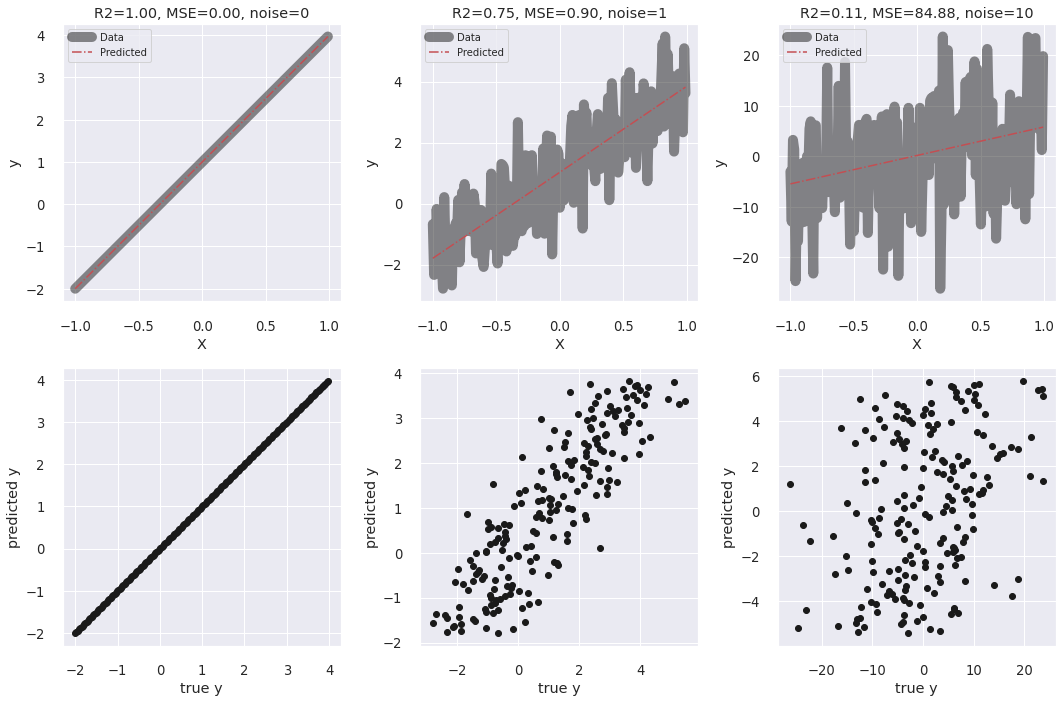

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures#calling the polynomial feature that will calculate the powers of our features
##here it is not necessary since our model is pretty simple, 
# but you will see in the next example how cool this function is.
from sklearn.preprocessing import StandardScaler# always scale your coobservable either using standard scaler or 
# making them of unit 1. Check the documentation of the function you are using : 
# some do it automatically other not, other need you to specify the normalization.

X=np.ndarray.reshape(np.arange(-1,1,10**-2),200,1)
fig,ax=plt.subplots(2,3,figsize=(15,10))

for k,epsilon in enumerate([0,1,10]):
    y=[1+3*v +epsilon*np.random.randn() for v in X[:,0]]




    poly = PolynomialFeatures(degree=1)#here we settle for a first degree polynomial object, 
    # play with that an see how the model reacts
    X_poly=poly.fit_transform(X)#do the actual fit and transformation of data : 
    #                                      now it is in the format of a polynomial

    from sklearn.preprocessing import StandardScaler# always scale your coobservable either using standard scaler or 
    # making them of unit 1. Check the documentation of the function you are using : 
    # some do it automatically other not, other need you to specify the normalization.
    scaler=StandardScaler()
    scaler.fit_transform(X_poly)#your data are scaled!


    lr=LinearRegression()
    lr.fit(X_poly,y)#fit the linear prediction
    y_predict=lr.predict(X_poly)# predict back what your target variable would be in that model
    R2=r2_score(y,y_predict)#evaluate R2
    MSE=mean_squared_error(y,y_predict)#evaluate MSE


    ax[0,k].plot(X[:,0],y,'k-',label='Data',linewidth=10,alpha=0.5)
    ax[0,k].plot(X[:,0],y_predict,'r-.',label='Predicted')
    ax[0,k].legend(loc='best',fontsize=10)
    ax[0,k].set_title('R2={0:.2f}, MSE={1:.2f}, noise={2}'.format(R2,MSE,epsilon))
    ax[0,k].set_xlabel('X')
    ax[0,k].set_ylabel('y')
    
    ax[1,k].plot(y,y_predict,'ko')
    ax[1,k].set_xlabel('true y')
    ax[1,k].set_ylabel('predicted y')
    print('epsilon',epsilon)
    print('fit param',lr.coef_,lr.intercept_)
    print('true param',[0,3],1)
    print()
plt.tight_layout()
plt.show()

epsilon 0
fit param [0.      0.60024] 0.988001200000002
true param [0, -3, 0, 6] 1

epsilon 1
fit param [0.       0.748654] 0.8771390480917379
true param [0, -3, 0, 6] 1

epsilon 10
fit param [ 0.         -0.54594557] 1.134383539074497
true param [0, -3, 0, 6] 1



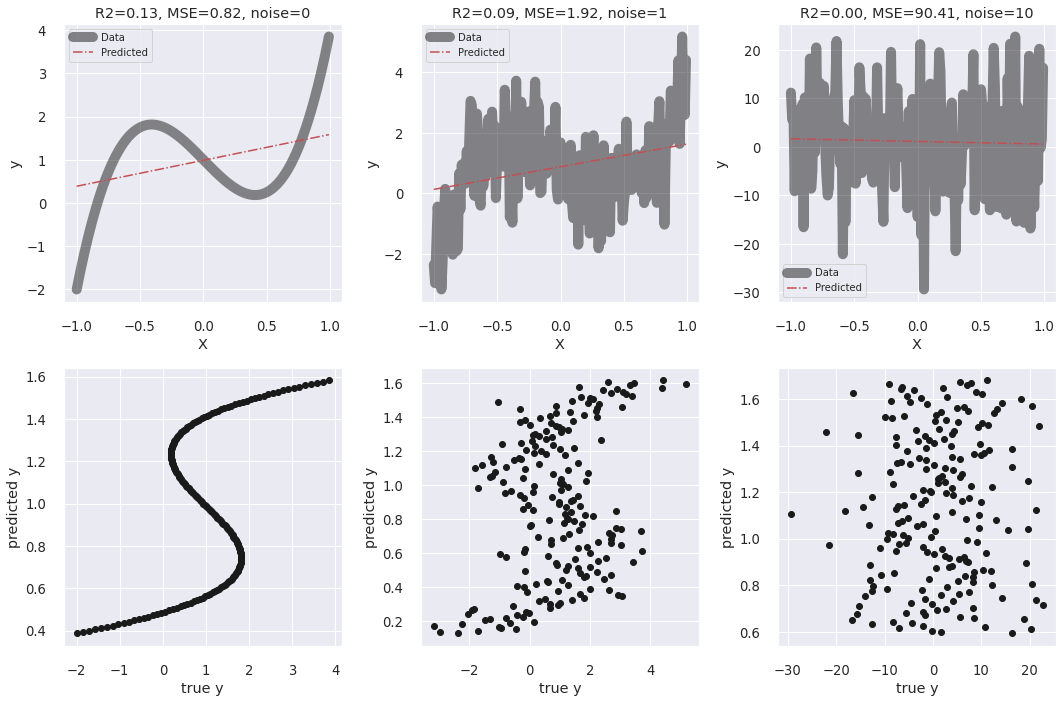

In [38]:
X=np.ndarray.reshape(np.arange(-1,1,10**-2),200,1)
fig,ax=plt.subplots(2,3,figsize=(15,10))

for k,epsilon in enumerate([0,1,10]):
    y=[1-3*v+6*v**3 +epsilon*np.random.randn() for v in X[:,0]]




    poly = PolynomialFeatures(degree=1)#here we settle for a first degree polynomial object, 
    # play with that an see how the model reacts
    X_poly=poly.fit_transform(X)#do the actual fit and transformation of data : 
    #                                      now it is in the format of a polynomial

    from sklearn.preprocessing import StandardScaler# always scale your coobservable either using standard scaler or 
    # making them of unit 1. Check the documentation of the function you are using : 
    # some do it automatically other not, other need you to specify the normalization.
    scaler=StandardScaler()
    scaler.fit_transform(X_poly)#your data are scaled!


    lr=LinearRegression()
    lr.fit(X_poly,y)#fit the linear prediction
    y_predict=lr.predict(X_poly)# predict back what your target variable would be in that model
    R2=r2_score(y,y_predict)#evaluate R2
    MSE=mean_squared_error(y,y_predict)#evaluate MSE


    ax[0,k].plot(X[:,0],y,'k-',label='Data',linewidth=10,alpha=0.5)
    ax[0,k].plot(X[:,0],y_predict,'r-.',label='Predicted')
    ax[0,k].legend(loc='best',fontsize=10)
    ax[0,k].set_title('R2={0:.2f}, MSE={1:.2f}, noise={2}'.format(R2,MSE,epsilon))
    ax[0,k].set_xlabel('X')
    ax[0,k].set_ylabel('y')
    
    ax[1,k].plot(y,y_predict,'ko')
    ax[1,k].set_xlabel('true y')
    ax[1,k].set_ylabel('predicted y')
    print('epsilon',epsilon)
    print('fit param',lr.coef_,lr.intercept_)
    print('true param',[0,-3,0,6],1)
    print()
plt.tight_layout()
plt.show()

Ok so that's not great.... But we could have guessed that this model would be bad since it is clearly a third degree polynomial that links X to y. We can do better by using a 'trick' (actually it is a trick that we used before in SVM, and a trick that you can use in logistic regression too!!!). Let's artificially increase the number of dimension of our features set : let's calculate $X^{2}$ and $X^{3}$ and consider them as features. After all a polynomial is just a linear combination of different monomials.

$y=wX +b$ is a linear combination of X

$y=w_{1}X+w_{2}X^{2}+w_{3}X^{3}$ is still a linear combination of feature X, $X^{2}$ and $X^{3}$

You can call from sklearn.preprocessing import PolynomialFeatures and it will do all those X transformations for you. You might think it is a little bit unecessary to call a function for that, but wait to see when we will have to do the same in higher dimensions.

epsilon 0
fit param [ 0.00000000e+00 -3.00000000e+00 -7.54497701e-16  6.00000000e+00] 0.9999999999999997
true param [0, -3, 0, 6] 1

epsilon 1
fit param [ 0.         -2.94556785  0.10029015  6.14620007] 1.059406567473052
true param [0, -3, 0, 6] 1

epsilon 10
fit param [ 0.          0.28866738 -0.78304061  1.45949799] 1.6423922990897084
true param [0, -3, 0, 6] 1



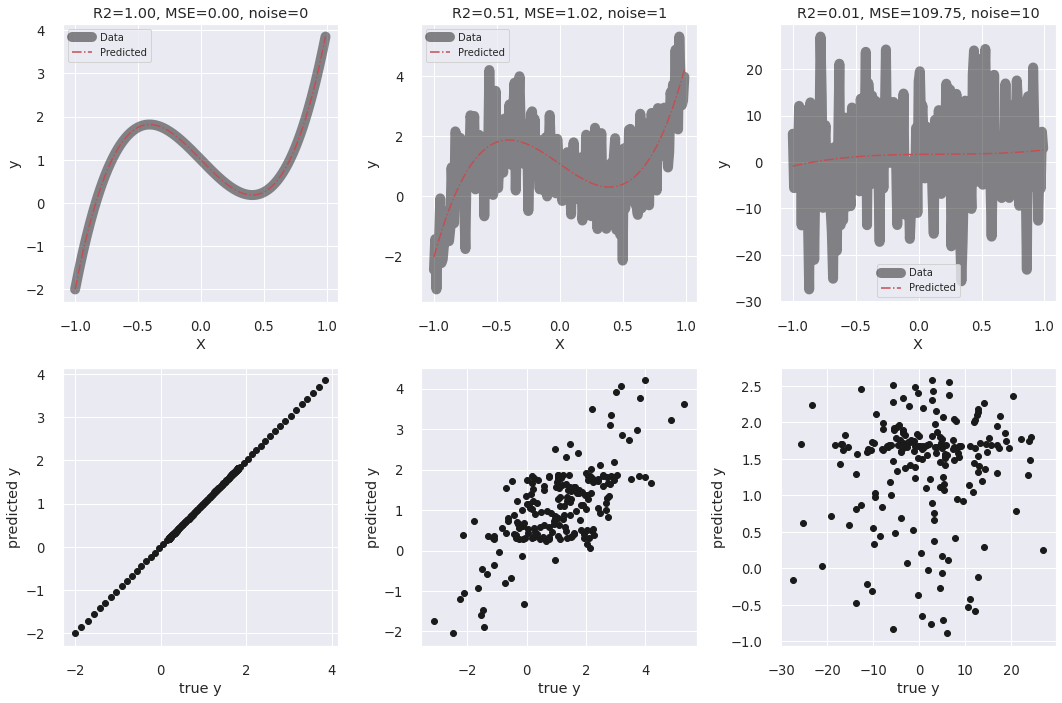

In [37]:
X=np.ndarray.reshape(np.arange(-1,1,10**-2),200,1)
fig,ax=plt.subplots(2,3,figsize=(15,10))

for k,epsilon in enumerate([0,1,10]):
    y=[1-3*v+6*v**3 +epsilon*np.random.randn() for v in X[:,0]]




    poly = PolynomialFeatures(degree=3)#here we settle for a first degree polynomial object, 
    # play with that an see how the model reacts
    X_poly=poly.fit_transform(X)#do the actual fit and transformation of data : 
    #                                      now it is in the format of a polynomial

    from sklearn.preprocessing import StandardScaler# always scale your coobservable either using standard scaler or 
    # making them of unit 1. Check the documentation of the function you are using : 
    # some do it automatically other not, other need you to specify the normalization.
    scaler=StandardScaler()
    scaler.fit_transform(X_poly)#your data are scaled!


    lr=LinearRegression()
    lr.fit(X_poly,y)#fit the linear prediction
    y_predict=lr.predict(X_poly)# predict back what your target variable would be in that model
    R2=r2_score(y,y_predict)#evaluate R2
    MSE=mean_squared_error(y,y_predict)#evaluate MSE


    ax[0,k].plot(X[:,0],y,'k-',label='Data',linewidth=10,alpha=0.5)
    ax[0,k].plot(X[:,0],y_predict,'r-.',label='Predicted')
    ax[0,k].legend(loc='best',fontsize=10)
    ax[0,k].set_title('R2={0:.2f}, MSE={1:.2f}, noise={2}'.format(R2,MSE,epsilon))
    ax[0,k].set_xlabel('X')
    ax[0,k].set_ylabel('y')
    
    ax[1,k].plot(y,y_predict,'ko')
    ax[1,k].set_xlabel('true y')
    ax[1,k].set_ylabel('predicted y')
    print('epsilon',epsilon)
    print('fit param',lr.coef_,lr.intercept_)
    print('true param',[0,-3,0,6],1)
    print()
plt.tight_layout()
plt.show()

Now you can actually do the same for more initial features: let's see with a 2D problem

In this case the function we are fitting is the following:

$y=w_{1}X_{1}+w_{2}X_{2}+w_{3}X_{1}^{2}+w_{4}X_{1}X_{2}+w_{5}X_{2}^{2}+w_{6}X_{1}^{3}+w_{7}X_{1}^{2}X_{2}+w_{8}X_{1}X_{2}^2+w_{9}X_{2}^{3}+b$

So you see that by artificially increasing the number of dimensions of your data you can bring some non linear feature fit into the game and expand your set of models to explore. The only thing you have to do is to consider monomes as features (polynomial feature will calcuate it for you). 

This artificial dimension increasing is actually another way to understand what the other dot products in SVM were doing. In principle using the dot product called polynomial was actually doing the exact same thing that we are doing now but in a smarter way (the dot product method actually doesn't transform the data but uses the dot product to calculate distances as if the data was tranformed in the higher dimension space).

So I didn't want to bring too much information back then, but you can actually use the same trick of transforming your data to higher polynomial order in your logistic regression for classification. 

(200, 2)
The order of polynomials coefficient according to the feature power.
      For example: [1 0] is our second monomial and stand for X1, 
      [1 1] is our 5th monomial and stand for X1*X2 
 [[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]


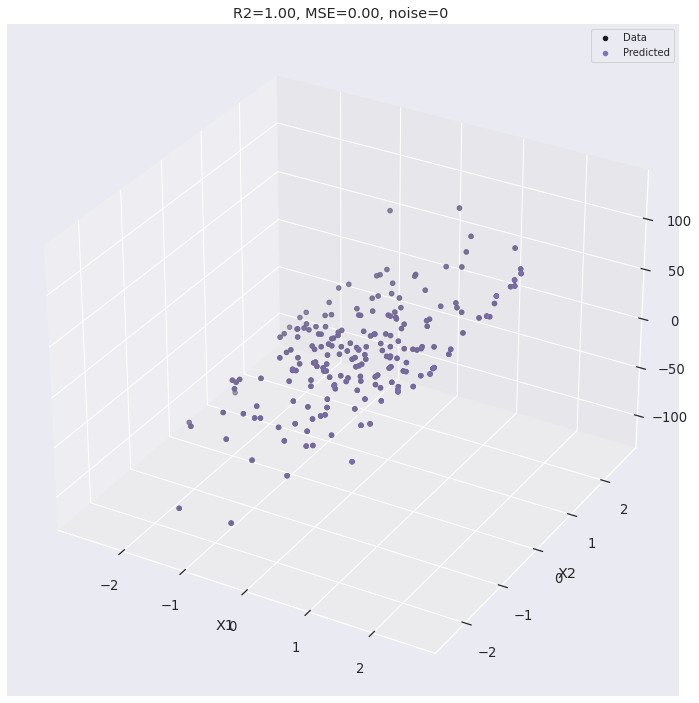

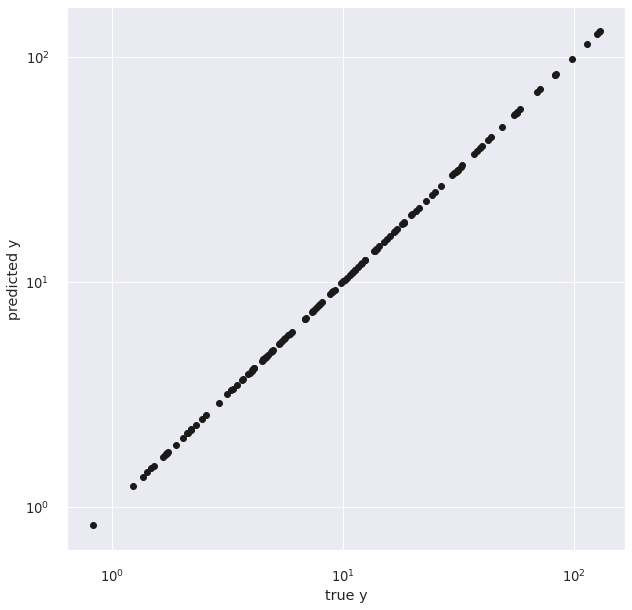

fit param [ 0.   4.   1.   2.   0.5 -1.   6.  -0.5  4.   5. ] 3.9999999999999964
true param [[0, 4, 1, 2, 0.5, -1, 6, -0.5, 4, 5], 4]


In [49]:
X2=np.ndarray.reshape(np.random.randn(400),200,2)
print(np.shape(X2))
np.random.seed(42)
epsilon=0
y2=[4*v+u+2*v**2+0.5*v*u-1*u**2+6*v**3-0.5*v**2*u+4*v*u*u+5*u**3 +4 +epsilon*np.random.randn() \
    for v,u in zip(X2[:,0],X2[:,1])]

#the function is a multivariate (2D) polynomial of degree 3 : that's 10 coefficients...
# Here I put the noise to 0 but please play with that number to see how it affects 
# your data and the model predicitions.

from mpl_toolkits.mplot3d import Axes3D

poly = PolynomialFeatures(degree=3)

X_poly=poly.fit_transform(X2)
print('''The order of polynomials coefficient according to the feature power.
      For example: [1 0] is our second monomial and stand for X1, 
      [1 1] is our 5th monomial and stand for X1*X2 \n''',poly.powers_)
lr=LinearRegression()
lr.fit(X_poly,y2)
y_predict=lr.predict(X_poly)
R2=r2_score(y2,y_predict)
MSE=mean_squared_error(y2,y_predict)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c='k',label='Data', depthshade=True)

ax.scatter(X2[:,0],X2[:,1],y_predict,label='Predicted' ,color='m')
plt.legend(loc='best',fontsize=10)
plt.title('R2={0:.2f}, MSE={1:.2f}, noise={2} '.format(R2,MSE,epsilon))
plt.xlabel('X1')
plt.ylabel('X2')
plt.tight_layout()

plt.show()
plt.plot(y2,y_predict,'ko')
plt.xlabel('true y')
plt.ylabel('predicted y')
plt.yscale('log')
plt.xscale('log')
plt.show()
print('fit param',lr.coef_,lr.intercept_)
print('true param',[[0,4,1,2,0.5,-1,6,-0.5,4,5],4])

Now you can already see that the polynomial transformation of your data brings an hyperparameter to be chosen. Indeed what see what happens if we misspecify the model for our first example which was a a basic affine function?

epsilon 0
fit param [ 0.00000000e+00  3.00000000e+00  2.37405598e-15 -3.17142387e-16] 0.9999999999999992
true param [0, 3] 1

epsilon 1
fit param [ 0.          3.05227457 -0.09362046 -0.30168317] 1.0867220429249511
true param [0, 3] 1

epsilon 10
fit param [ 0.          6.16302424 -0.85929796 -3.12244347] 0.5384742710992134
true param [0, 3] 1



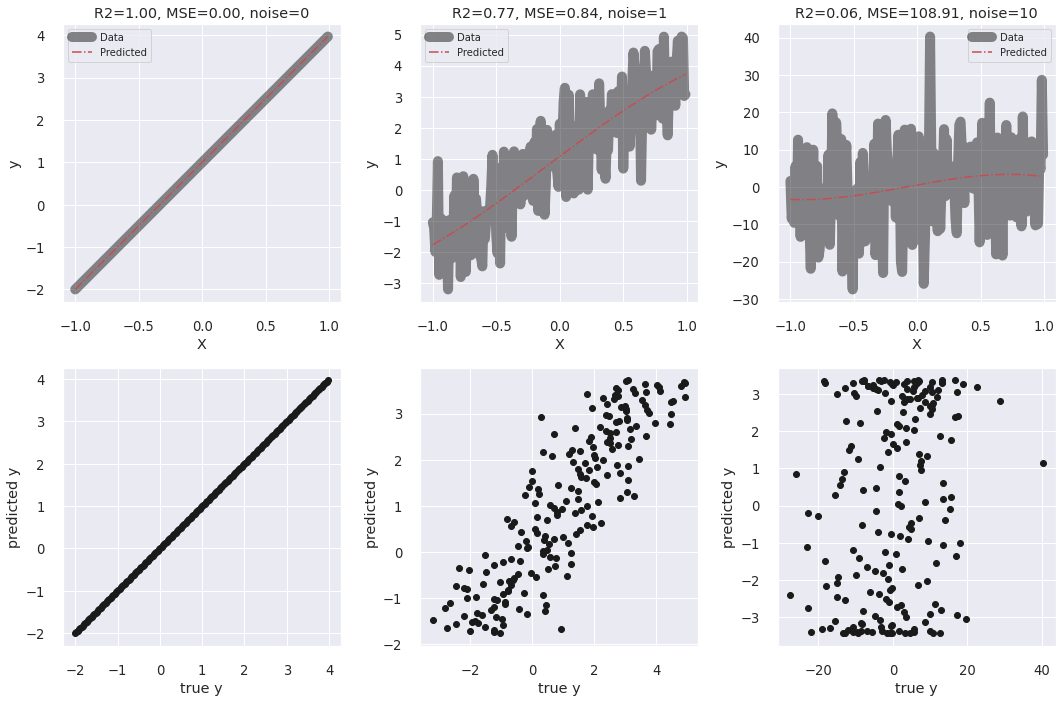

In [39]:
X=np.ndarray.reshape(np.arange(-1,1,10**-2),200,1)
fig,ax=plt.subplots(2,3,figsize=(15,10))

for k,epsilon in enumerate([0,1,10]):
    y=[1+3*v +epsilon*np.random.randn() for v in X[:,0]]




    poly = PolynomialFeatures(degree=3)#here we settle for a first degree polynomial object, 
    # play with that an see how the model reacts
    X_poly=poly.fit_transform(X)#do the actual fit and transformation of data : 
    #                                      now it is in the format of a polynomial

    from sklearn.preprocessing import StandardScaler# always scale your coobservable either using standard scaler or 
    # making them of unit 1. Check the documentation of the function you are using : 
    # some do it automatically other not, other need you to specify the normalization.
    scaler=StandardScaler()
    scaler.fit_transform(X_poly)#your data are scaled!


    lr=LinearRegression()
    lr.fit(X_poly,y)#fit the linear prediction
    y_predict=lr.predict(X_poly)# predict back what your target variable would be in that model
    R2=r2_score(y,y_predict)#evaluate R2
    MSE=mean_squared_error(y,y_predict)#evaluate MSE


    ax[0,k].plot(X[:,0],y,'k-',label='Data',linewidth=10,alpha=0.5)
    ax[0,k].plot(X[:,0],y_predict,'r-.',label='Predicted')
    ax[0,k].legend(loc='best',fontsize=10)
    ax[0,k].set_title('R2={0:.2f}, MSE={1:.2f}, noise={2}'.format(R2,MSE,epsilon))
    ax[0,k].set_xlabel('X')
    ax[0,k].set_ylabel('y')
    
    ax[1,k].plot(y,y_predict,'ko')
    ax[1,k].set_xlabel('true y')
    ax[1,k].set_ylabel('predicted y')
    print('epsilon',epsilon)
    print('fit param',lr.coef_,lr.intercept_)
    print('true param',[0,3],1)
    print()
plt.tight_layout()
plt.show()

So we will have to use a pipeline that transfroms our data into polynomials of different degree before feeding it to the linear regression, and that pipeline will then be used to find the good polynomial degree thanks to GridSearchCV.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from operator import itemgetter
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(X_diabetes, y_diabetes,
                                                   random_state=0)

lr=LinearRegression()

pipeline_lr=Pipeline([('poly',PolynomialFeatures()),('scalar',StandardScaler()),
                     ('model',lr)])#poly first then scalar!!!

from sklearn.model_selection import GridSearchCV


grid_values = {'poly__degree': np.arange(1,10,1)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='r2')#Feed it to the GridSearchCV with the right
#score over which the decision should be taken. Here r2 score

grid_lr_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_lr_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

# Again you need to retrain your model with the best parameters to have access to other functions like the coefficient of your
#linear regression

poly=PolynomialFeatures(degree=grid_lr_acc.best_params_['poly__degree'])
X_diabetes_train_poly=poly.fit_transform(X_diabetes_train)

scaler = StandardScaler() 
scaler.fit(X_diabetes_train_poly)
X_diabetes_train_poly_scaled=scaler.transform(X_diabetes_train_poly)

LR=LinearRegression()
LR.fit(X_diabetes_train_poly_scaled,y_diabetes_train)
poly.powers_
sorted_list=sorted([['_'.join([diabetes['feature_names'][j]+'^'+str(poly.powers_[i][j])for j in range(len(diabetes['feature_names'])) if poly.powers_[i][j]>0]),abs(LR.coef_[i])] for i in range(len(poly.powers_))],key=itemgetter(1),reverse=True)
#print('Important features',sorted([[diabetes['feature_names'][i],abs(LR.coef_[i+1])] for i in range(len(LR.coef_))],key=itemgetter(1),reverse=True))

print('Important features\n')
for s in sorted_list:
    print(s[0],s[1])


Grid best parameter (max. r2):  {'poly__degree': 1}
Grid best score (r2):  0.512236034526856
Grid best parameter (max. r2) model on test:  0.35940090989715534
Important features

s5^1 34.45846500270392
bmi^1 28.854824802553253
s1^1 26.52011216567283
bp^1 14.336039690123549
s2^1 12.38436283103843
sex^1 9.9377475830242
s4^1 6.595990045480257
age^1 2.0820143903823016
s6^1 1.4146397742594672
s3^1 0.4223910365596811
 0.0


In [41]:
for s1,s2 in zip(diabetes['feature_names'],'age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu'.split(',')):
    print(s1,s2)

age age
sex sex
bmi bmi
bp map
s1 tc
s2 ldl
s3 hdl
s4 tch
s5 ltg
s6 glu


### Let's add some regularization

Now that we added regularization there is noanalytical solution and we need to use an optimizer

In [44]:
from sklearn.linear_model import SGDRegressor

lr_reg=SGDRegressor()# This is a special function : it uses Stochastic gradient Descent for its optimization algo. You can
#change the loss function and the learning rate. But we will not mess with that here. The learning rate adjustement is made
#cleverly by default(many ways to be clever see API description) and we will stick to the MSE loss.

pipeline_lr_reg=Pipeline([('poly',PolynomialFeatures()),('scalar',StandardScaler()),
                     ('model',lr_reg)])#poly first then scalar!!!

from sklearn.model_selection import GridSearchCV


grid_values = {'poly__degree': np.arange(1,10,1),'model__penalty':['l1','l2'],'model__alpha':np.logspace(0,3,10)}#define the hyperparameters you want to test
#with the range over which you want it to be tested. Here alpha is the weight for the regularization

grid_lr_reg_acc = GridSearchCV(pipeline_lr_reg, param_grid = grid_values, scoring='r2',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_lr_reg_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_lr_reg_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_lr_reg_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_lr_reg_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric


poly=PolynomialFeatures(degree=grid_lr_reg_acc.best_params_['poly__degree'])
X_diabetes_train_poly=poly.fit_transform(X_diabetes_train)

scaler = StandardScaler() 
scaler.fit(X_diabetes_train_poly)
X_diabetes_train_poly_scaled=scaler.transform(X_diabetes_train_poly)

lr_reg=SGDRegressor(penalty=grid_lr_reg_acc.best_params_['model__penalty'],alpha=grid_lr_reg_acc.best_params_['model__alpha'])
lr_reg.fit(X_diabetes_train_poly_scaled,y_diabetes_train)
poly.powers_
sorted_list=sorted([['_'.join([diabetes['feature_names'][j]+'^'+str(poly.powers_[i][j])for j in range(len(diabetes['feature_names'])) if poly.powers_[i][j]>0]),abs(lr_reg.coef_[i])] for i in range(len(poly.powers_))],key=itemgetter(1),reverse=True)
#print('Important features',sorted([[diabetes['feature_names'][i],abs(lr_reg.coef_[i+1])] for i in range(len(lr_reg.coef_))],key=itemgetter(1),reverse=True))

print('Important features\n')
for s in sorted_list:
    print(s[0],s[1])


Grid best parameter (max. r2):  {'model__alpha': 2.154434690031884, 'model__penalty': 'l1', 'poly__degree': 1}
Grid best score (r2):  0.5199152998510458
Grid best parameter (max. r2) model on test:  0.35551647446573664
Important features

bmi^1 28.985284257525898
s5^1 23.77306272685353
bp^1 11.561749344978034
s3^1 11.156416242051515
sex^1 6.0966252646147705
s2^1 3.7520940757126104
 0.0
age^1 0.0
s1^1 0.0
s4^1 0.0
s6^1 0.0


# KNN <a class="anchor" id="KNN"></a>

You can also use the KNN algorithm for regression. Again you get the n nearest neighbors of the point you want to predict but this time instead of a vote it does a local average of the neighbours value (again weighted or not by their distance to your querry point)

No handles with labels found to put in legend.


(200, 2)


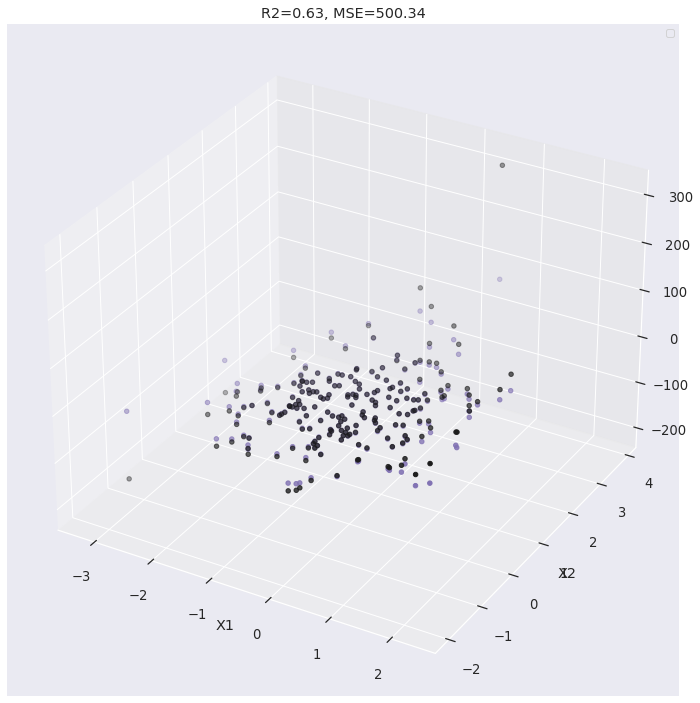

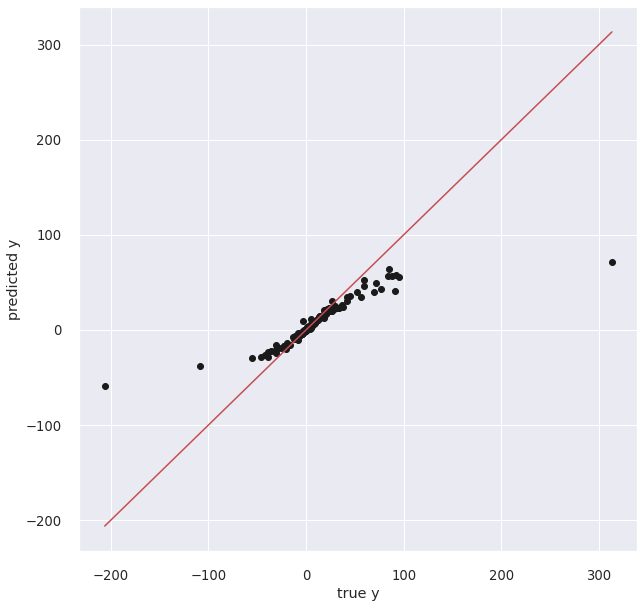

In [52]:
from sklearn.neighbors import KNeighborsRegressor
np.random.seed(42)
X2=np.ndarray.reshape(np.random.randn(400),200,2)
print(np.shape(X2))
epsilon=0
y2=[4*v+u+2*v**2+0.5*v*u-1*u**2+6*v**3-0.5*v**2*u+4*v*u*u+5*u**3 +4 +epsilon*np.random.randn() \
    for v,u in zip(X2[:,0],X2[:,1])]

poly = PolynomialFeatures(degree=3)

X_poly=poly.fit_transform(X2)

knn=KNeighborsRegressor(n_neighbors=10)#try different number of neighbors
knn.fit(X_poly,y2)
y_predict=knn.predict(X_poly)
R2=r2_score(y2,y_predict)
MSE=mean_squared_error(y2,y_predict)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c='k', depthshade=True)

ax.scatter(X2[:,0],X2[:,1],y_predict ,color='m')
plt.legend(loc='best',fontsize=10)
plt.title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
plt.xlabel('X1')
plt.ylabel('X2')
plt.tight_layout()

plt.show()
plt.plot(y2,y_predict,'ko')
plt.plot([min([min(y2),min(y_predict)]),max([max(y2),max(y_predict)])],[min([min(y2),min(y_predict)]),max([max(y2),max(y_predict)])],'r-')
plt.xlabel('true y')
plt.ylabel('predicted y')
plt.show()
#print('fit param',lr.coef_,lr.intercept_)
#print('true param',[[0,4,1,2,-0.5,-1,6,-0.5,4,5],4])

KNN regressor is not really good at predicting sparse neigborhoods. Here, because some points are rare events from my normal sampling on X  and that these rare events are inflated by the polynmial function, it results that for the extreme points the knn doing the average of near neighbors is not accurate.

In [72]:
knn=KNeighborsRegressor()

pipeline_knn=Pipeline([('scalar',StandardScaler()),
                     ('model',knn)])

from sklearn.model_selection import GridSearchCV


grid_values = {'model__weights':['uniform','distance'],
               'model__n_neighbors':np.arange(1,30,1)}# define the hyperparameters you want to test
#with the range over which you want it to be tested. Here epsilon behave as our limit distance |f(x)-y| for which we don't
#penalize the model (our support vector if you will)

grid_knn_acc = GridSearchCV(pipeline_knn, param_grid = grid_values, scoring='r2',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_knn_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_knn_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_knn_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_knn_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric




scaler = StandardScaler() 
scaler.fit(X_diabetes_train)
X_diabetes_train_scaled=scaler.transform(X_diabetes_train)

knn=KNeighborsRegressor(weights=grid_knn_acc.best_params_['model__weights'],
                 n_neighbors=grid_knn_acc.best_params_['model__n_neighbors'],
                 )
knn.fit(X_diabetes_train_scaled,y_diabetes_train)



Grid best parameter (max. r2):  {'model__n_neighbors': 11, 'model__weights': 'distance'}
Grid best score (r2):  0.5029383656025505
Grid best parameter (max. r2) model on test:  0.2821832644378929


KNeighborsRegressor(n_neighbors=11, weights='distance')

# SVM <a class="anchor" id="SVM"></a>

In SVM regression the algo is almost the same as classifier SVM with yet one big difference. In classification we were looking at the hyperplane that was as far as possible from our support vector. In regression you look for the hyperplanes that are as close as possible from you support vector. That's it, nothing more complicated than that.

No handles with labels found to put in legend.


(200, 2)


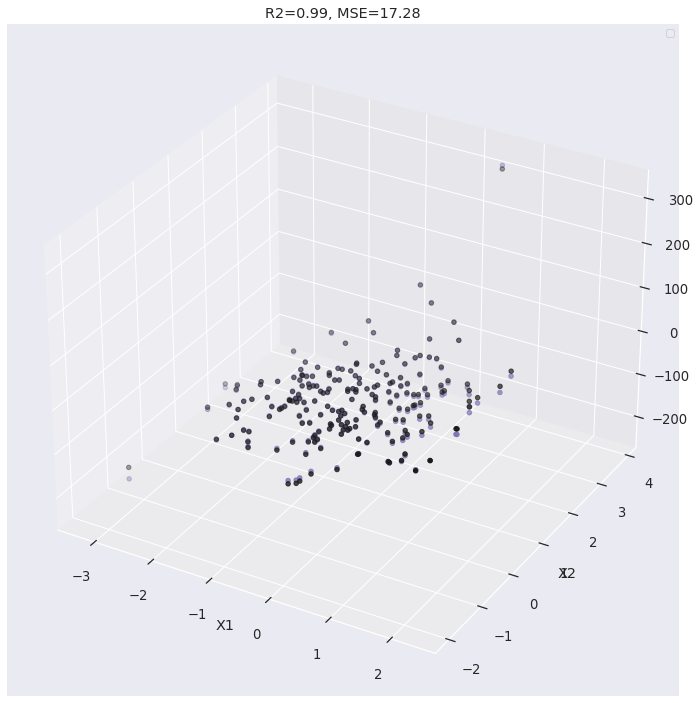

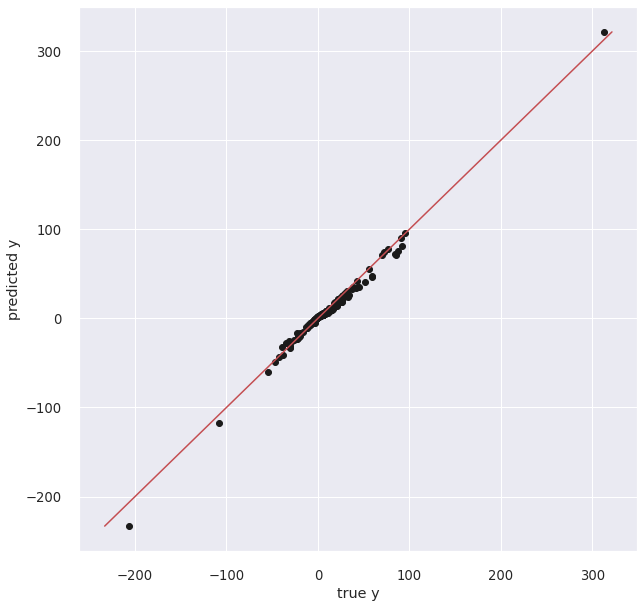

In [56]:
from sklearn.svm import SVR
np.random.seed(42)
X2=np.ndarray.reshape(np.random.randn(400),200,2)
print(np.shape(X2))
epsilon=0
y2=[4*v+u+2*v**2+0.5*v*u-1*u**2+6*v**3-0.5*v**2*u+4*v*u*u+5*u**3 +4 +epsilon*np.random.randn() \
    for v,u in zip(X2[:,0],X2[:,1])]


svr=SVR(kernel='poly',degree=3)
svr.fit(X2,y2)
y_predict=svr.predict(X2)
R2=r2_score(y2,y_predict)
MSE=mean_squared_error(y2,y_predict)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:,0], X2[:,1], y2, s=20, c='k', depthshade=True)

ax.scatter(X2[:,0],X2[:,1],y_predict ,color='m')
plt.legend(loc='best',fontsize=10)
plt.title('R2={0:.2f}, MSE={1:.2f}'.format(R2,MSE))
plt.xlabel('X1')
plt.ylabel('X2')
plt.tight_layout()

plt.show()
plt.plot(y2,y_predict,'ko')
plt.plot([min([min(y2),min(y_predict)]),max([max(y2),max(y_predict)])],[min([min(y2),min(y_predict)]),max([max(y2),max(y_predict)])],'r-')
plt.xlabel('true y')
plt.ylabel('predicted y')
plt.show()

In [69]:
from sklearn.svm import SVR

svr=SVR()

pipeline_svr=Pipeline([('scalar',StandardScaler()),
                     ('model',svr)])

from sklearn.model_selection import GridSearchCV


grid_values = {'model__kernel':['linear','poly','rbf'],
               'model__degree':np.arange(1,4,1),
               'model__epsilon':np.logspace(-2,0,10),
               'model__C':np.logspace(-2,2,10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested. Here epsilon behave as our limit distance |f(x)-y| for which we don't
#penalize the model (our support vector if you will)

grid_svr_acc = GridSearchCV(pipeline_svr, param_grid = grid_values, scoring='r2',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_svr_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_svr_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_svr_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_svr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric




scaler = StandardScaler() 
scaler.fit(X_diabetes_train)
X_diabetes_train_scaled=scaler.transform(X_diabetes_train)

svr=SVR(kernel=grid_svr_acc.best_params_['model__kernel'],
                 degree=grid_svr_acc.best_params_['model__degree'],
                 epsilon=grid_svr_acc.best_params_['model__epsilon'],
                 C=grid_svr_acc.best_params_['model__C'],
                 )
svr.fit(X_diabetes_train_scaled,y_diabetes_train)

# Again non linear kernel might be good at doing the fitting job but are bad if you want to interpret them...

if grid_svr_acc.best_params_['model__kernel']=='linear':
    print('Important features',sorted([[diabetes['feature_names'][i],abs(svr.coef_[0][i])] for i in range(len(svr.coef_[0]))],key=itemgetter(1),reverse=True))


Grid best parameter (max. r2):  {'model__C': 35.93813663804626, 'model__degree': 1, 'model__epsilon': 0.3593813663804626, 'model__kernel': 'rbf'}
Grid best score (r2):  0.5240247886291846
Grid best parameter (max. r2) model on test:  0.293095664075564


# Gradient boosting tree <a class="anchor" id="Gradient"></a>

Gradient boosted is made for regression (you saw that already)! It is even simpler than what we saw before since you don't have to do all those transformations and just go for minimizing the MSE loss function. So let's check it out.

In [73]:
from sklearn.ensemble import GradientBoostingRegressor


grid_values = {'learning_rate':np.arange(0.01,0.1,0.01),
                'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_diabetes_train)),20),
               'min_samples_split':np.arange(2,int(len(X_diabetes_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_diabetes_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(GradientBoostingRegressor(), param_grid = grid_values, scoring='r2',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_diabetes_test_c=grid_tree_acc.predict(X_diabetes_test)



Grid best parameter (max. r2):  {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 2, 'n_estimators': 101}
Grid best score (r2):  0.5013090496563358
Grid best parameter (max. r2) model on test:  0.2876487557329962


In [74]:
RFC = GradientBoostingRegressor(learning_rate=grid_tree_acc.best_params_['learning_rate'],
                            n_estimators=grid_tree_acc.best_params_['n_estimators'],
                            max_depth=grid_tree_acc.best_params_['max_depth'],
                            min_samples_split=grid_tree_acc.best_params_['min_samples_split'],
                           min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'])
RFC.fit(X_diabetes_train, y_diabetes_train)
w=RFC.feature_importances_#get the weights

sorted_features=sorted([[diabetes['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
for s in sorted_features:
    print(s[0],s[1])

Features sorted per importance in discriminative process
[['s5', 0.42880856190016026], ['bmi', 0.3035948173864764], ['bp', 0.0757722501972807], ['s3', 0.06837908288159025], ['s6', 0.04263305333754875], ['age', 0.021209615527889147], ['s2', 0.020414998384435674], ['sex', 0.016162796182997752], ['s4', 0.015465118417645045], ['s1', 0.007559705783976005]]


# Exercice: go back to the automobil dataset and this time instead of classifying by type of price, predict the prices <a class="anchor" id="exo"></a>

Try linear regression (with different degrees if you wish) and gradient boosting tree. What do you learn about prices?

In [9]:
import pandas as pd
df = pd.read_csv('Automobile_data.csv')
df.replace("?", np.nan, inplace = True)

avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

avg_bore=df['bore'].astype('float').mean(axis=0)
df["bore"].replace(np.nan, avg_bore, inplace=True)

avg_stroke=df['stroke'].astype('float').mean(axis=0)
df["stroke"].replace(np.nan, avg_stroke, inplace=True)

avg_horsepower = df['horsepower'].astype('float').mean(axis=0)
df['horsepower'].replace(np.nan, avg_horsepower, inplace=True)

avg_price = df['price'].astype('float').mean(axis=0)
df['price'].replace(np.nan, avg_price, inplace=True)

avg_peakrpm=df['peak-rpm'].astype('float').mean(axis=0)
df['peak-rpm'].replace(np.nan, avg_peakrpm, inplace=True)

#like replacing by the max used for example
print(df['num-of-doors'].value_counts())
print(df['num-of-doors'].value_counts().idxmax())

df["num-of-doors"].replace(np.nan, "four", inplace=True)

#If your interested in lines rather than columns you can drop lines (index) for which a certaine feature is NAN.
df.dropna(subset=["price"], axis=0, inplace=True)

df.reset_index(drop=True, inplace=True)

df["horsepower"]=df["horsepower"].astype(int, copy=True)

df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")
df[["peak-rpm"]] = df[["peak-rpm"]].astype("float")

X=pd.DataFrame([[df[v][i] for v in df.columns if v!='price'] for i in range(len(df['price']))],index=df.index,columns=[v for v in df.columns if v!='price'])
dico={'Low':0,'Medium':1,'High':2}
y=pd.DataFrame([[df['price'][i]] for i in range(len(df['price']))],index=df.index,columns=['price'])

keep=[]
for i in range(len(X.columns)):
    if X.dtypes[X.columns[i]]=='object':
        keep.append(X.columns[i])
        dummy_variable_1 = pd.get_dummies(X[X.columns[i]])
        X = pd.concat([X, dummy_variable_1], axis=1)


X.drop(keep,axis = 1, inplace=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)

four    114
two      89
Name: num-of-doors, dtype: int64
four


#Next cell is correction!So work above!

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#




#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#


#

# One possible correction

In [46]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from operator import itemgetter

lr_reg=SGDRegressor()# This is a special function : it uses Stochastic gradient Descent for it's optimization algo. You can
#change the loss function and the learning rate. But we will not mess with that here. The learning rate adjustement is made
#cleverly by default(many ways to be clever see API description) and we will stick to the MSE loss.

pipeline_lr_reg=Pipeline([('poly',PolynomialFeatures()),('scalar',StandardScaler()),
                     ('model',lr_reg)])#poly first then scalar!!!

from sklearn.model_selection import GridSearchCV


grid_values = {'poly__degree': np.arange(1,4,1),'model__penalty':['l1','l2'],'model__alpha':np.logspace(0,3,10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested. Here alpha is the weight for the regularization

grid_lr_reg_acc = GridSearchCV(pipeline_lr_reg, param_grid = grid_values, scoring='r2')#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_lr_reg_acc.fit(X_train, np.array(y_train).ravel())

y_decision_fn_scores_acc=grid_lr_reg_acc.score(X_test,np.array(y_test).ravel())

print('Grid best parameter (max. r2): ', grid_lr_reg_acc.best_params_)#get the best parameters
print('Grid best score (r2): ', grid_lr_reg_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric


poly=PolynomialFeatures(degree=grid_lr_reg_acc.best_params_['poly__degree'])
X_train_poly=poly.fit_transform(X_train)

scaler = StandardScaler() 
scaler.fit(X_train_poly)
X_train_poly_scaled=scaler.transform(X_train_poly)

lr_reg=SGDRegressor(penalty=grid_lr_reg_acc.best_params_['model__penalty'],alpha=grid_lr_reg_acc.best_params_['model__alpha'])
lr_reg.fit(X_train_poly_scaled,np.array(y_train).ravel())
poly.powers_
sorted_list=sorted([['_'.join([X.columns[j]+'^'+str(poly.powers_[i][j])for j in range(len(X.columns)) if poly.powers_[i][j]>0]),abs(lr_reg.coef_[i])] for i in range(len(poly.powers_))],key=itemgetter(1),reverse=True)
#print('Important features',sorted([[diabetes['feature_names'][i],abs(lr_reg.coef_[i+1])] for i in range(len(lr_reg.coef_))],key=itemgetter(1),reverse=True))

print('Important features\n',sorted_list)

Grid best parameter (max. r2):  {'model__alpha': 100.0, 'model__penalty': 'l1', 'poly__degree': 1}
Grid best score (r2):  0.9126058578010559
Grid best parameter (max. r2) model on test:  0.7177474509176134
Important features
 [['bmw^1', 1336.392171626729], ['width^1', 1094.6997969649053], ['mercedes-benz^1', 1086.1945308312725], ['engine-size^1', 1067.0255218083817], ['jaguar^1', 1020.5952031570549], ['horsepower^1', 947.7817014790522], ['curb-weight^1', 934.3162585023243], ['porsche^1', 707.9261817261637], ['rear^1', 707.9261817261637], ['front^1', 707.9261817261593], ['four^1', 649.1148905151886], ['convertible^1', 583.697696442062], ['eight^1', 583.1461361023081], ['wheel-base^1', 540.632033018392], ['rwd^1', 515.5781162390118], ['toyota^1', 228.94114280337095], ['saab^1', 202.75311239729012], ['mitsubishi^1', 201.9784976396949], ['sedan^1', 181.05656163849753], ['volvo^1', 175.7823766286346], ['ohcv^1', 144.83510431299564], ['peugot^1', 143.36440189454953], ['l^1', 143.364401894549